In [35]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from MTCNN_nets import PNet, RNet, ONet
import math
import os
import time

In [36]:
HW = time.perf_counter()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [37]:
pnet = PNet().to(device)
rnet = RNet().to(device)
onet = ONet().to(device)

pnet.load_state_dict(torch.load('C:/Minh_Duc/MD_Personal/LVTN/Training_MTCNN/weights-backup/Pnet_weight.pth', map_location=device))
rnet.load_state_dict(torch.load('C:/Minh_Duc/MD_Personal/LVTN/Training_MTCNN/weights-backup/Rnet_weight.pth', map_location=device))
onet.load_state_dict(torch.load('C:/Minh_Duc/MD_Personal/LVTN/Training_MTCNN/weights-backup/Onet_weight.pth', map_location=device))

pnet.eval()
rnet.eval()
onet.eval()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15268\2597670193.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pnet.load_state_dict(torch.load('C:/Minh_Duc/MD_Personal/LVT

ONet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=32)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=64)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=64)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (prelu4): PReLU(num_parameters=128)
    (flatten): Flatten()
    (conv5): Linear(in_features=1152, out_features=256, bias=True)
    (drop5): Dropout(p=0.5, inplace=False)
    (prelu5): PReLU(num_parameters=256)
  )
  (conv6_1): Linear(in_features=256, out_features=2, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, bi

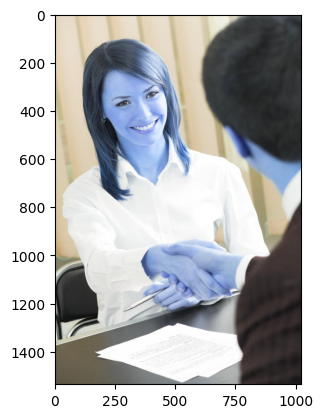

In [38]:
# Image loading
image_path = "C:/Minh_Duc/MD_Personal/LVTN/Training_MTCNN/dataset/test/images/1_Handshaking_Handshaking_1_331_jpg.rf.ca72e5a6c142849ffd624779763f2da7.jpg"
image = cv2.imread(image_path)
plt.imshow(image)
plt.show()

In [39]:
if image is None:
    print(f"Error: Could not load image {image_path}")
    exit()
height, width, channel = image.shape
min_length = min(height, width)
print(f"Image shape: {image.shape}")

# Parameters
min_face_size = 20.0
thresholds = [0.7, 0.7, 0.4]  # O-Net threshold at 0.7
nms_thresholds = [0.7, 0.7, 0.7]
min_detection_size = 12
factor = 0.707

Image shape: (1536, 1024, 3)


In [40]:
def preprocess(img):
    img = img[:, :, ::-1]  # BGR to RGB
    img = np.asarray(img, 'float32')
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)

    img = (img - 127.5) * 0.0078125
    return img


In [41]:
def nms(boxes, overlap_threshold=0.5, mode='union'):
    if len(boxes) == 0:
        return []
    pick = []
    x1, y1, x2, y2, score = [boxes[:, i] for i in range(5)]
    area = (x2 - x1 + 1.0) * (y2 - y1 + 1.0)
    ids = np.argsort(score)
    while len(ids) > 0:
        last = len(ids) - 1
        i = ids[last]
        pick.append(i)
        ix1 = np.maximum(x1[i], x1[ids[:last]])
        iy1 = np.maximum(y1[i], y1[ids[:last]])
        ix2 = np.minimum(x2[i], x2[ids[:last]])
        iy2 = np.minimum(y2[i], y2[ids[:last]])
        w = np.maximum(0.0, ix2 - ix1 + 1.0)
        h = np.maximum(0.0, iy2 - iy1 + 1.0)
        inter = w * h
        if mode == 'min':
            overlap = inter / np.minimum(area[i], area[ids[:last]])
        else:
            overlap = inter / (area[i] + area[ids[:last]] - inter)
        ids = np.delete(ids, np.concatenate([[last], np.where(overlap > overlap_threshold)[0]]))
    return pick


In [42]:
def calibrate_box(bboxes, offsets):
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)
    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


In [43]:
# Convert to square boxes
def convert_to_square(bboxes):
    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    square_bboxes[:, 4] = bboxes[:, 4]
    return square_bboxes

In [44]:
# Correct bounding boxes
def correct_bboxes(bboxes, width, height):
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]
    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0
    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0
    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0
    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0
    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]
    return return_list

In [45]:
# Stage 1: P-Net
scales = []
m = min_detection_size / min_face_size
min_length *= m
factor_count = 0
while min_length > min_detection_size:
    scales.append(m * factor ** factor_count)
    min_length *= factor
    factor_count += 1

bounding_boxes = []
with torch.no_grad():
    for scale in scales:
        sw, sh = math.ceil(width * scale), math.ceil(height * scale)
        img = cv2.resize(image, (sw, sh), interpolation=cv2.INTER_LINEAR)
        img = torch.FloatTensor(preprocess(img)).to(device)
        offset, prob = pnet(img)
        probs = prob.cpu().data.numpy()[0, 1, :, :]
        offsets = offset.cpu().data.numpy()
        stride, cell_size = 2, 12
        inds = np.where(probs > thresholds[0])
        if inds[0].size == 0:
            boxes = None
        else:
            tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
            offsets = np.array([tx1, ty1, tx2, ty2])
            score = probs[inds[0], inds[1]]
            bounding_box = np.vstack([
                np.round((stride * inds[1] + 1.0) / scale),
                np.round((stride * inds[0] + 1.0) / scale),
                np.round((stride * inds[1] + 1.0 + cell_size) / scale),
                np.round((stride * inds[0] + 1.0 + cell_size) / scale),
                score, offsets
            ])
            boxes = bounding_box.T
            keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
            boxes = boxes[keep]
        if boxes is not None:
            bounding_boxes.append(boxes)

# Combine and process P-Net boxes
bounding_boxes = [i for i in bounding_boxes if i is not None]
if len(bounding_boxes) == 0:
    print("No boxes detected by P-Net")
    exit()
bounding_boxes = np.vstack(bounding_boxes)
print(f"P-Net: {bounding_boxes.shape[0]} boxes before NMS")
keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
bounding_boxes = bounding_boxes[keep]
bboxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
bboxes = convert_to_square(bboxes)
bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
print(f"P-Net: {bboxes.shape[0]} boxes after processing")

# Visualize P-Net results
pnet_img = image.copy()
for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    cv2.rectangle(pnet_img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), 1)

# Stage 2: R-Net
size = 24
num_boxes = len(bboxes)
print(f"R-Net: Received {num_boxes} boxes from P-Net")
[dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)
img_boxes = np.zeros((num_boxes, 3, size, size))
for i in range(num_boxes):
    img_box = np.zeros((h[i], w[i], 3))
    img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]
    if img_box.shape[0] == 0 or img_box.shape[1] == 0:
        print(f"Warning: Empty patch for R-Net box {i}: {bboxes[i, :4]}")
        continue
    img_box = cv2.resize(img_box, (size, size), interpolation=cv2.INTER_LINEAR)
    img_boxes[i, :, :, :] = preprocess(img_box)

if num_boxes > 0:
    img_boxes = torch.FloatTensor(img_boxes).to(device)
    offset, prob = rnet(img_boxes)
    offsets = offset.cpu().data.numpy()
    probs = prob.cpu().data.numpy()
    print(f"R-Net: Probabilities shape: {probs.shape}, max score: {np.max(probs[:, 1]) if probs.size > 0 else 'N/A'}")
    keep = np.where(probs[:, 1] > thresholds[1])[0]
    print(f"R-Net: {len(keep)} boxes above threshold {thresholds[1]}")
    bboxes = bboxes[keep]
    bboxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    keep = nms(bboxes, nms_thresholds[1])
    bboxes = bboxes[keep]
    bboxes = calibrate_box(bboxes, offsets[keep])
    bboxes = convert_to_square(bboxes)
    bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
    print(f"R-Net: {bboxes.shape[0]} boxes after processing")
else:
    bboxes = np.array([])
    print("R-Net: No boxes to process")

# Visualize R-Net results
rnet_img = image.copy()
for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    cv2.rectangle(rnet_img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 1)

# Stage 3: O-Net (No Landmarks)
size = 48
num_boxes = len(bboxes)
print(f"O-Net: Received {num_boxes} boxes from R-Net")
if num_boxes > 0:
    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size))
    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3))
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]
        if img_box.shape[0] == 0 or img_box.shape[1] == 0:
            print(f"Warning: Empty patch for O-Net box {i}: {bboxes[i, :4]}")
            continue
        img_box = cv2.resize(img_box, (size, size), interpolation=cv2.INTER_LINEAR)
        img_boxes[i, :, :, :] = preprocess(img_box)

    img_boxes = torch.FloatTensor(img_boxes).to(device)
    landmarks, offset, prob = onet(img_boxes)  # Handle three outputs, ignore landmarks
    offsets = offset.cpu().data.numpy()
    probs = prob.cpu().data.numpy()
    print(f"O-Net: Probabilities shape: {probs.shape}, max score: {np.max(probs[:, 1]) if probs.size > 0 else 'N/A'}")
    keep = np.where(probs[:, 1] > thresholds[2])[0]
    print(f"O-Net: {len(keep)} boxes above threshold {thresholds[2]}")
    bboxes = bboxes[keep]
    bboxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    keep = nms(bboxes, nms_thresholds[2], mode='min')
    bboxes = bboxes[keep]
    bboxes = calibrate_box(bboxes, offsets[keep])
    bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
    print(f"O-Net: {bboxes.shape[0]} boxes after processing")
else:
    bboxes = np.array([])
    print("O-Net: No boxes to process")

# Visualize O-Net results
onet_img = image.copy()
for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    cv2.rectangle(onet_img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

P-Net: 40 boxes before NMS
P-Net: 40 boxes after processing
R-Net: Received 40 boxes from P-Net
R-Net: Probabilities shape: (40, 2), max score: 0.9215194582939148
R-Net: 5 boxes above threshold 0.7
R-Net: 3 boxes after processing
O-Net: Received 3 boxes from R-Net
O-Net: Probabilities shape: (3, 2), max score: 0.46810317039489746
O-Net: 1 boxes above threshold 0.4
O-Net: 1 boxes after processing


7.495773700007703


(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

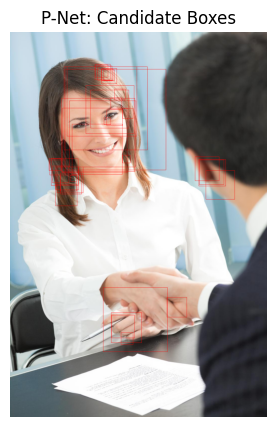

In [46]:
print(time.perf_counter()-HW)
# Display all stages
plt.figure(figsize=(15, 5))

# P-Net
plt.subplot(1, 3, 1)
plt.imshow(pnet_img[:, :, ::-1])
plt.title('P-Net: Candidate Boxes')
plt.axis('off')

(np.float64(-0.5), np.float64(1023.5), np.float64(1535.5), np.float64(-0.5))

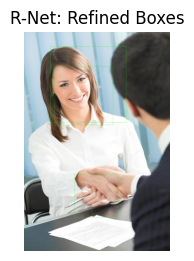

In [47]:
# R-Net
plt.subplot(1, 3, 2)
plt.imshow(rnet_img[:, :, ::-1])
plt.title('R-Net: Refined Boxes')
plt.axis('off')

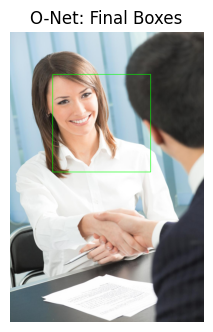

In [48]:
# O-Net
plt.subplot(1, 3, 3)
plt.imshow(onet_img[:, :, ::-1])
plt.title('O-Net: Final Boxes')
plt.axis('off')

plt.tight_layout()
plt.show()